# RNN Modeling 

Note: Run notebook in Google Colab if tensorflow is not installed

**Summary**

In this notebook we will develop two recurrent neural networks to predict drought. Drought is the measurement of low precipitation over a given time period [National Weather Service]('https://www.weather.gov/bmx/kidscorner_drought'). For this reason we will use the 'precipitation' column as our target variable and use features we explored in our eda_new_data.ipynb notebook. The data collected shows the regions mean daily accounts of weather patterns by merging the information provided by the nearest weather stations. [Visual Crossing Weather]('https://www.visualcrossing.com/resources/documentation/weather-data/modifying-the-weather-station-search-parameters/') 

Our first RNN model will use data collected from the region of California.
- Our baseline model will be a NaiveForecaster with a RMSE of 0.052
- Time distribution will be in Days 
- Success will be determined if it performs better than our baseline model 

Our second RNN model will use data collected from the region of Fresno, California. 
- Our baseline model will be a NaiveForecaster with a RMSE of 0.052
- Time distribution will be in Days 
- Success will be determined if it performs better than our baseline model 


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LSTM
from sklearn.metrics import r2_score, mean_squared_error

Necessary step if using google colab. If not, ignore and include direction when reading in csv.

In [3]:
from google.colab import files
uploaded = files.upload()

Saving eda_data.csv to eda_data.csv


## RNN Model - Day 

---

In [4]:
df = pd.read_csv('eda_data.csv', index_col='datetime', parse_dates=True)
df.sort_index(inplace = True)
df.shape

(18234, 30)

In [5]:
df.head()

,name,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,conditions,description,icon,stations,clear-day,cloudy,fog,partly-cloudy-day,rain_icon,wind
datetime,,,,,,,,,,,,,,,,,,,,,
1970-01-01,California,52.7,29.5,37.5,52.7,29.5,37.0,29.7,74.3,0.0,...,Partially cloudy,Clearing in the afternoon.,partly-cloudy-day,"74516023202,99999923232,72483623208,72483793216",0,0,0,1,0,0
1970-01-02,California,53.5,27.4,38.2,53.5,27.4,38.0,29.1,70.8,0.0,...,Clear,Clear conditions throughout the day.,clear-day,"74516023202,99999923232,72483623208,72483793216",1,0,0,0,0,0
1970-01-03,California,52.4,27.5,38.5,52.4,27.5,37.8,27.7,66.3,0.0,...,Clear,Clear conditions throughout the day.,clear-day,"74516023202,99999923232,72483623208,72483793216",1,0,0,0,0,0
1970-01-04,California,50.3,27.4,36.9,50.3,26.4,34.8,27.5,69.6,0.0,...,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"74516023202,99999923232,72483623208,72483793216",0,0,0,1,0,0
1970-01-05,California,48.5,27.2,36.4,48.5,24.4,35.5,27.9,71.8,0.0,...,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"74516023202,99999923232,72483623208,72483793216",0,0,0,1,0,0


In [7]:
df.isnull().sum()

name                 0
tempmax              0
tempmin              0
temp                 0
feelslikemax         0
feelslikemin         0
feelslike            0
dew                  0
humidity             0
precip               0
precipprob           0
precipcover          0
windspeed            0
winddir              0
sealevelpressure     0
cloudcover           0
visibility           0
sunrise              0
sunset               0
moonphase            0
conditions           0
description          0
icon                 0
stations             0
clear-day            0
cloudy               0
fog                  0
partly-cloudy-day    0
rain_icon            0
wind                 0
dtype: int64

In [8]:
features = df.drop(columns = ['precip', 'name', 'precipprob', 'precipcover', 'sunrise', 'sunset', 'conditions', 'description', 'icon', 'stations'], axis=1)
X = features
y = df['precip']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size=0.005)

In [10]:
X_train.tail()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,clear-day,cloudy,fog,partly-cloudy-day,rain_icon,wind
datetime,,,,,,,,,,,,,,,,,,,,
2021-09-27,79.5,55.6,65.6,79.5,55.6,65.6,55.4,72.2,18.2,201.8,1015.3,33.7,9.9,0.72,0,0,0,1,0,0
2021-09-28,79.8,55.4,65.7,79.8,55.4,65.7,37.1,40.3,21.2,321.1,1015.5,8.0,9.9,0.75,1,0,0,0,0,0
2021-09-29,84.7,47.8,65.2,81.6,47.8,64.7,36.7,39.8,13.0,321.7,1014.3,4.0,9.9,0.78,1,0,0,0,0,0
2021-09-30,86.6,49.5,66.4,83.1,49.5,65.7,39.8,45.0,5.6,56.5,1014.9,0.3,9.9,0.82,1,0,0,0,0,0
2021-10-01,88.2,52.6,69.3,84.5,52.6,68.5,41.1,40.2,5.0,6.1,1014.3,3.5,9.9,0.85,1,0,0,0,0,0


In [11]:
X_test.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,clear-day,cloudy,fog,partly-cloudy-day,rain_icon,wind
datetime,,,,,,,,,,,,,,,,,,,,
2021-10-02,90.0,54.0,70.4,85.9,54.0,69.4,43.0,42.9,5.6,310.6,1014.9,3.0,9.9,0.88,1,0,0,0,0,0
2021-10-03,88.3,55.5,69.8,84.6,55.5,69.0,44.1,44.2,4.9,329.0,1013.7,5.3,9.9,0.91,1,0,0,0,0,0
2021-10-04,88.4,53.5,69.6,84.9,53.5,68.9,44.3,44.2,5.2,187.7,1011.7,4.0,9.4,0.95,1,0,0,0,0,0
2021-10-05,82.6,58.9,68.1,80.5,58.9,67.9,44.2,44.5,15.3,186.9,1012.1,12.7,9.9,0.98,1,0,0,0,0,0
2021-10-06,74.6,56.9,63.3,74.6,56.9,63.3,49.6,64.5,17.4,195.9,1014.1,18.4,9.9,0.00,1,0,0,0,0,0


In [12]:
X_train.shape, X_test.shape

((18142, 20), (92, 20))

In [13]:
y_train.shape, y_test.shape

((18142,), (92,))

In [14]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

#### RNN Model - Day (analysis)

Before running our first model we use TimeseriesGenerator to format our train and test sets. We decided to use a lag length of 3 because our data is in days and dosen't show any sign of trend. Iterations of the model have already been executed. Code block [18] shows the final and best performing iteration of our first model. I am using LSTM instead of GRU for my model because my dataset contains a fairly large amount of values which LSTM performs better with. 


In [15]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length = 3,
                                      batch_size = 64)

In [16]:
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length = 3, batch_size = 64)

In [17]:
input_shape = train_sequences[0][0][0].shape

In [18]:
model = Sequential()

model.add(LSTM(16, input_shape = input_shape, return_sequences = True)) 
model.add(LSTM(32, return_sequences = False))
model.add(Dense(16, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.05))
model.add(Dense(8, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1, activation = None))


In [19]:
model.compile(loss = 'mean_squared_error',
              optimizer = 'adam')

es = EarlyStopping(patience = 5)

history = model.fit(train_sequences,
                    validation_data = test_sequences,
                    callbacks = [es],
                    epochs = 50)

Epoch 1/50
284/284 [==============================] - 9s 11ms/step - loss: 0.1795 - val_loss: 0.3958
Epoch 2/50
284/284 [==============================] - 3s 10ms/step - loss: 0.0545 - val_loss: 0.3707
Epoch 3/50
284/284 [==============================] - 3s 9ms/step - loss: 0.0434 - val_loss: 0.3549
Epoch 4/50
284/284 [==============================] - 4s 12ms/step - loss: 0.0423 - val_loss: 0.3501
Epoch 5/50
284/284 [==============================] - 3s 10ms/step - loss: 0.0416 - val_loss: 0.3526
Epoch 6/50
284/284 [==============================] - 2s 8ms/step - loss: 0.0419 - val_loss: 0.3588
Epoch 7/50
284/284 [==============================] - 2s 8ms/step - loss: 0.0413 - val_loss: 0.3573
Epoch 8/50
284/284 [==============================] - 2s 8ms/step - loss: 0.0413 - val_loss: 0.3468
Epoch 9/50
284/284 [==============================] - 3s 11ms/step - loss: 0.0412 - val_loss: 0.3488
Epoch 10/50
284/284 [==============================] - 2s 8ms/step - loss: 0.0409 - val_loss: 0

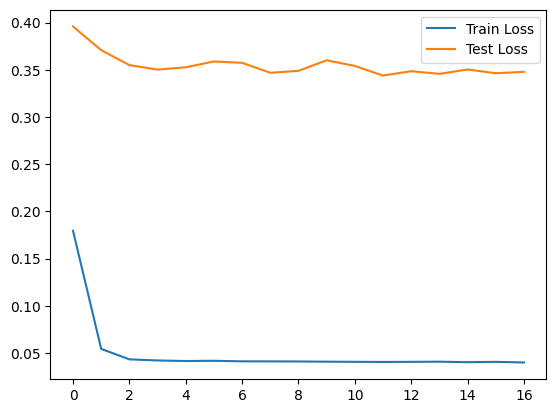

In [20]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Test Loss')
plt.title('RNN Day Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend();
plt.savefig('../images/day_model_mse.jpg')

In [21]:
model.evaluate(test_sequences)

2/2 [==============================] - 0s 12ms/step - loss: 0.3478


0.347811222076416

In [22]:
preds = model.predict(test_sequences)

2/2 [==============================] - 1s 7ms/step


In [23]:
len(preds)

89

In [24]:
preds_p = pd.Series(index= y_test.index[:-3], data= preds.reshape(89))

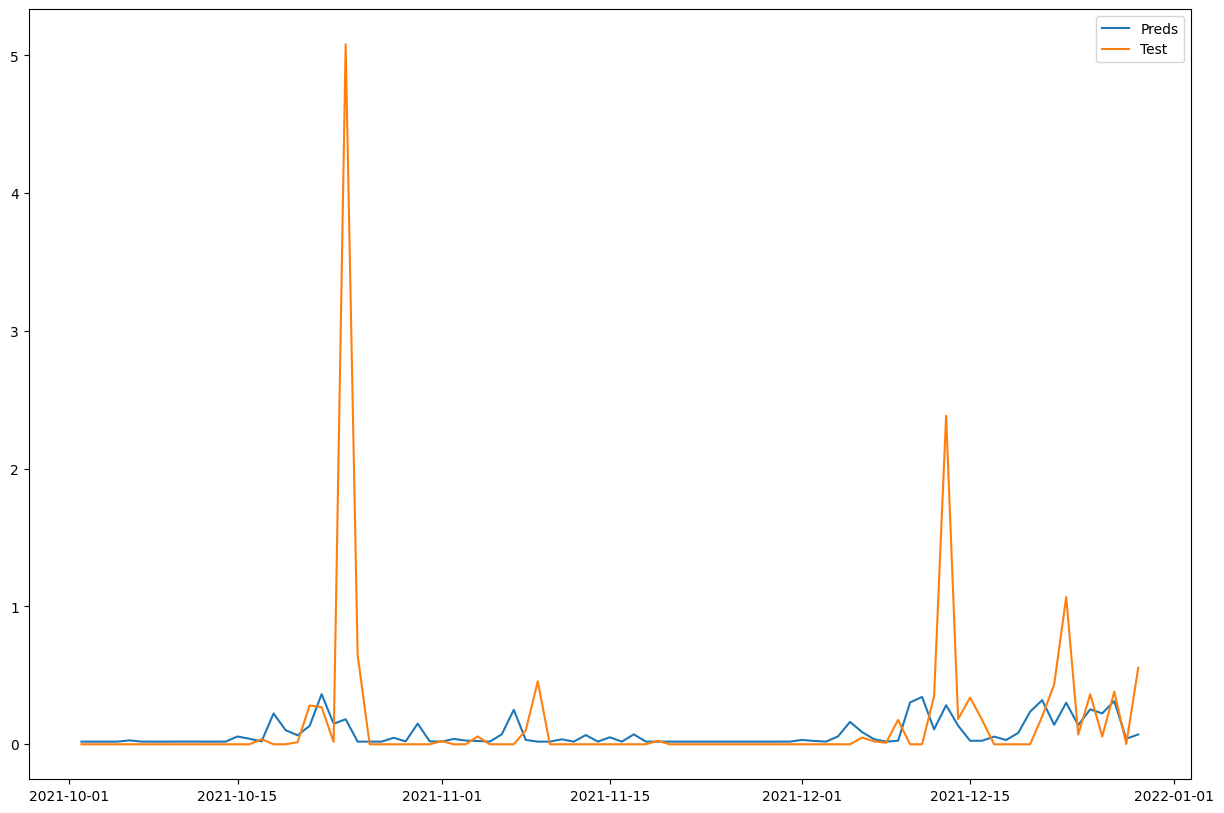

In [25]:

plt.figure(figsize=(15,10))
plt.plot(preds_p, label = 'Preds')
plt.plot(y_test[:-3], label = 'Test')
plt.legend(loc='best')
plt.title('RNN Day Model Predictions vs. Actual')
plt.ylabel('precip')
plt.show();
plt.savefig('../images/day_model_preds.jpg')

In [27]:
mean_squared_error(y_test[:-3], preds, squared=False)

0.5875640933989826

In [28]:
r2_score(y_test[:-3], preds)

0.05274585231079887

#### Conclusion of RNN Model - Days 

We can see in code-block figure [20] that our first RNN model is greatly overfit with ur train and test MSE scores having a difference of 0.3077. This model (RMSE: 0.588) also performed worse than our baseline NaiveForecaster (RMSE: 0.052). 
The scope of this model is fairly large. Our dataset consists of large mean averages of a state with a wide variety of weather conditions. Our time-series is also in days, causing our predictions to look 89 units into the future even though our test sample size amounts to 0.005% of the data. 
For our next model we will shorten the region of our data to the city of Fresno in California. We will also resample our timeframe to be in weeks to limit the extent of our predictions. 



---

## RNN Model - Week 



In [29]:
from google.colab import files
uploaded = files.upload()

Saving fresno_eda.csv to fresno_eda.csv


In [33]:
fresno = pd.read_csv('fresno_eda.csv', index_col='datetime', parse_dates=True)

In [34]:
fresno.shape

(10959, 30)

In [37]:
f_week = fresno.resample('W').mean(numeric_only=True)

In [44]:
f_week.isnull().sum()

tempmax              0
tempmin              0
temp                 0
feelslikemax         0
feelslikemin         0
feelslike            0
dew                  0
humidity             0
precip               0
precipprob           0
precipcover          0
windspeed            0
winddir              0
sealevelpressure     0
cloudcover           0
visibility           0
moonphase            0
clear-day            0
cloudy               0
fog                  0
partly-cloudy-day    0
rain_icon            0
wind                 0
dtype: int64

In [48]:
features = f_week.drop(columns = ['precip', 'precipprob', 'precipcover'], axis=1)
X_2 = features
y_2 = f_week['precip']

In [49]:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, shuffle = False, test_size=0.005)

In [50]:
X_2_train.tail()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,clear-day,cloudy,fog,partly-cloudy-day,rain_icon,wind
datetime,,,,,,,,,,,,,,,,,,,,
2021-10-10,79.371429,56.171429,67.300000,77.800000,55.814286,66.957143,43.885714,46.542857,11.357143,287.885714,1015.442857,41.757143,7.828571,0.332857,0.428571,0.000000,0.0,0.428571,0.142857,0.0
2021-10-17,75.885714,50.342857,62.242857,74.928571,49.942857,62.042857,32.514286,36.585714,14.985714,268.400000,1015.114286,17.485714,9.385714,0.297143,0.714286,0.000000,0.0,0.285714,0.000000,0.0
2021-10-24,72.142857,54.500000,62.900000,71.857143,53.742857,62.800000,44.200000,53.128571,12.328571,199.057143,1015.285714,71.785714,9.857143,0.537143,0.000000,0.142857,0.0,0.571429,0.285714,0.0
2021-10-31,71.271429,52.571429,61.257143,71.271429,52.342857,61.228571,52.914286,75.657143,9.771429,213.300000,1017.257143,46.471429,7.314286,0.764286,0.142857,0.000000,0.0,0.714286,0.142857,0.0
2021-11-07,71.514286,53.171429,61.671429,71.514286,53.028571,61.671429,51.942857,72.185714,11.142857,240.357143,1019.471429,51.285714,8.328571,0.427143,0.000000,0.000000,0.0,1.000000,0.000000,0.0


In [51]:
X_2_test.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,clear-day,cloudy,fog,partly-cloudy-day,rain_icon,wind
datetime,,,,,,,,,,,,,,,,,,,,
2021-11-14,64.400000,49.614286,56.271429,64.400000,49.371429,56.228571,51.214286,84.414286,7.671429,233.157143,1022.900000,66.385714,4.600000,0.241429,0.000000,0.142857,0.142857,0.428571,0.285714,0.0
2021-11-21,63.257143,49.800000,55.485714,63.257143,49.185714,55.385714,51.128571,86.228571,7.428571,299.571429,1020.200000,77.728571,2.728571,0.478571,0.000000,0.285714,0.000000,0.714286,0.000000,0.0
2021-11-28,64.042857,41.300000,50.757143,64.042857,39.728571,50.171429,43.228571,78.071429,6.542857,203.100000,1022.471429,46.114286,4.428571,0.712857,0.142857,0.000000,0.000000,0.857143,0.000000,0.0
2021-12-05,65.257143,43.885714,53.300000,65.257143,41.857143,52.828571,44.957143,76.114286,5.871429,241.614286,1021.042857,42.242857,4.085714,0.524286,0.428571,0.142857,0.000000,0.428571,0.000000,0.0
2021-12-12,55.157143,41.728571,48.142857,55.057143,39.400000,47.171429,43.042857,83.542857,7.714286,220.428571,1018.685714,74.571429,5.014286,0.190000,0.000000,0.142857,0.000000,0.714286,0.142857,0.0


In [52]:
ss = StandardScaler()

X_2_train_sc = ss.fit_transform(X_2_train)
X_2_test_sc = ss.transform(X_2_test)

#### RNN Model - Week (analysis)

Code block [56] shows the final and best performing iteration of our first model. I am using LSTM instead of GRU for my model because my dataset contains a fairly large amount of values which LSTM performs better with. 

In [53]:
train_sequences_2 = TimeseriesGenerator(X_2_train_sc, y_2_train, length = 3,
                                      batch_size = 64)

In [54]:
test_sequences_2 = TimeseriesGenerator(X_2_test_sc, y_2_test, length = 3, batch_size = 64)

In [55]:
input_shape_2 = train_sequences_2[0][0][0].shape

In [56]:
model_2 = Sequential()

model_2.add(LSTM(8, input_shape = input_shape_2, return_sequences = True))
model_2.add(LSTM(16, return_sequences = False)) 
model_2.add(Dense(8, activation = 'relu', kernel_regularizer=l2(0.01)))
model_2.add(Dropout(0.4))
model_2.add(Dense(1, activation = None))


In [57]:
model_2.compile(loss = 'mean_squared_error',
              optimizer = 'adam')

es = EarlyStopping(patience = 15)

history_2 = model_2.fit(train_sequences_2,
                    validation_data = test_sequences_2,
                    callbacks = [es],
                    epochs = 50)

Epoch 1/50
25/25 [==============================] - 7s 47ms/step - loss: 0.1063 - val_loss: 0.1010
Epoch 2/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0911 - val_loss: 0.0870
Epoch 3/50
25/25 [==============================] - 0s 10ms/step - loss: 0.0783 - val_loss: 0.0757
Epoch 4/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0675 - val_loss: 0.0661
Epoch 5/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0580 - val_loss: 0.0567
Epoch 6/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0495 - val_loss: 0.0492
Epoch 7/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0424 - val_loss: 0.0428
Epoch 8/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0363 - val_loss: 0.0363
Epoch 9/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0310 - val_loss: 0.0321
Epoch 10/50
25/25 [==============================] - 0s 12ms/step - loss: 0.0266 - val_loss: 0.0280
Epoch 11/50
25/2

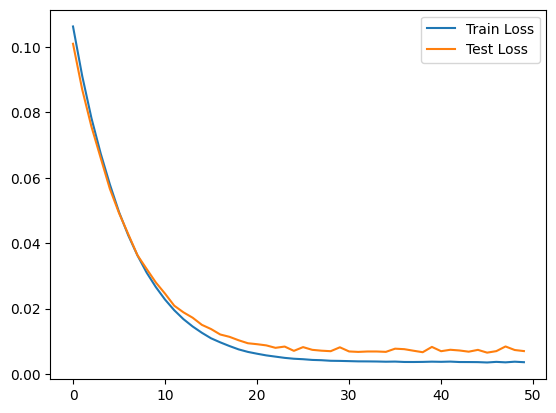

In [58]:
plt.plot(history_2.history['loss'], label = 'Train Loss')
plt.plot(history_2.history['val_loss'], label = 'Test Loss')
plt.legend();
plt.title('RNN Week Model MSE')
plt.xlabel('Epoch')
plt.ylabel('precip')
plt.savefig('../images/week_model_mse.jpg')

In [70]:
preds_2 = model_2.predict(test_sequences_2)

1/1 [==============================] - 0s 41ms/step


In [73]:
preds_2

array([[0.0382392 ],
       [0.03953741],
       [0.04362749],
       [0.05469416],
       [0.07145844]], dtype=float32)

In [72]:
y_2_test[:-3]


datetime
2021-11-14    0.040000
2021-11-21    0.000000
2021-11-28    0.000000
2021-12-05    0.000000
2021-12-12    0.054286
Freq: W-SUN, Name: precip, dtype: float64

In [62]:
preds_p_2 = pd.Series(index= y_2_test.index[:-3], data= preds_2.reshape(5))

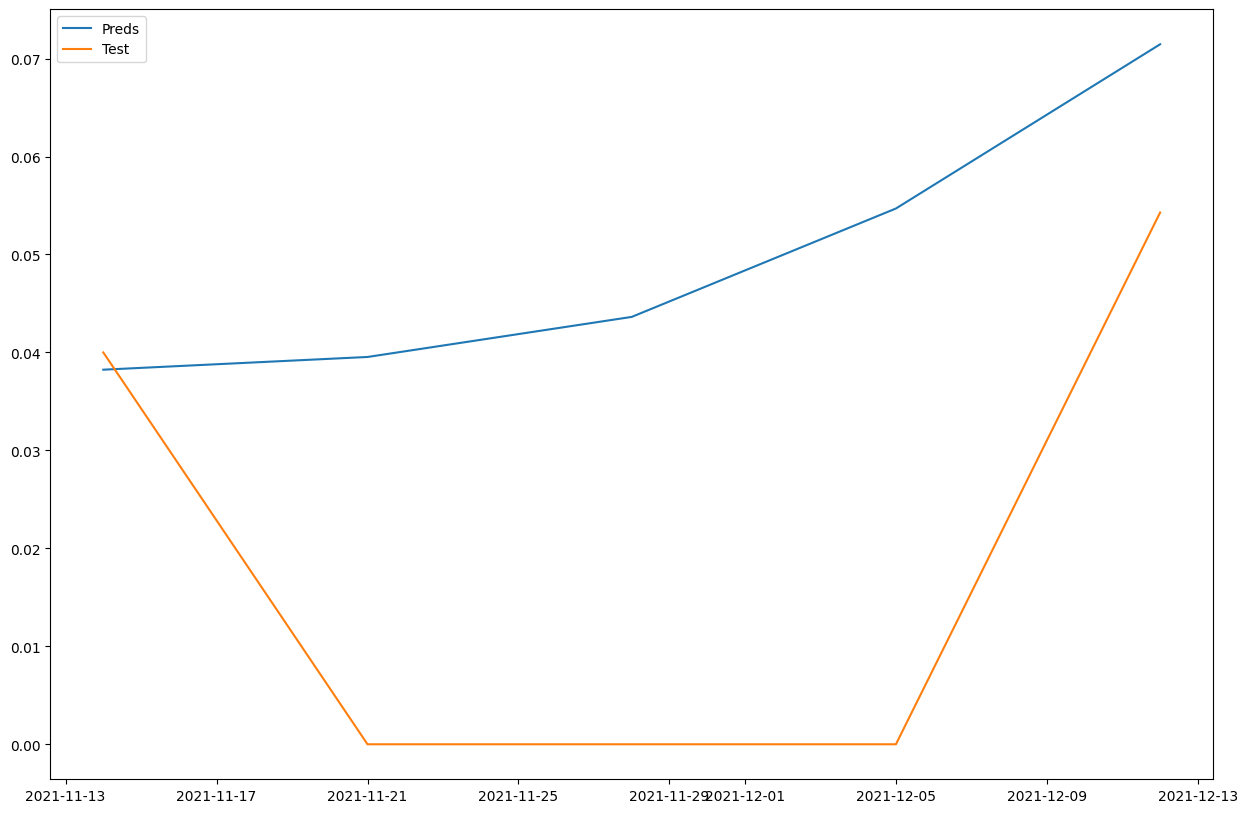

In [67]:
plt.figure(figsize=(15,10))
plt.plot(preds_p_2, label = 'Preds')
plt.plot(y_2_test[:-3], label = 'Test')
plt.legend(loc='best')
plt.title('RNN Week Model Predictions vs Actual')
plt.ylabel('precip')
plt.show()
plt.savefig('../images/week_model_preds.jpg')

In [68]:
mean_squared_error(y_2_test[:-3], preds_p_2, squared=False)

0.03675872402163581

In [74]:
r2_score(y_2_test[:-3], preds_p_2)

-1.4398948184419398

#### Conclusion of RNN Model - Week 

We can see in code-block figure [58] that our second RNN model fixed the overfit issues with a new MSE difference of 0.0034. This model (RMSE: 0.037) outperformed our baseline NaiveForecaster (RMSE: 0.052). 
The issue with both of these models is the relationship between our target and feature variables. Our target variable's variation can only be explained by 5% of our features of our best performing RNN model (week). This makes using these neural network models not very efficient because our features are not contributing seemingly at all. 
We will use sktime and stats models in the linear_ts_model.ipynb notebook because they don't rely on any feature variables.
